### imports and setup

In [1]:
# # google colab setup (comment out this cell if running locally)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd "/content/drive/My Drive/_research ML AQ/lorenz 96 gnn" # so we can access pre-generated lorenz data
# !pip3 install spektral

In [2]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
import matplotlib.pyplot as plt


In [4]:
# import packages
import numpy as np
import tensorflow as tf

from lorenz import lorenzDataset, DEFAULT_TIME_RESOLUTION
from plotters import plot_data
from tuning import make_train_GCN, make_train_GCN3, plot_model_results
from models import NaiveConstant, NaiveZero

from spektral.data import MixedLoader

from datetime import datetime

2023-02-21 08:30:30.874533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# check that GPU is set up
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('no GPU device found')
else:
    print('found GPU at: {}'.format(device_name))
print('num GPUs available:', len(tf.config.list_physical_devices("GPU")))

no GPU device found
num GPUs available: 0


2023-02-21 08:30:38.857343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### check data

#### predict from X1 & X2 input window

In [32]:
# only uncomment each line if testing a non-default parameter
dataset_x1x2window = lorenzDataset(
    predict_from="X1X2_window",
    n_samples=100,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42
    override=True
)

generating new Lorenz data and saving to file
generating window data
total steps: 400
integrating for 4.0 days at 100 resolution (i.e. 400 pts)
len t vs n_steps 400 400 True
starting integration
X.shape 100
Y.shape 100
t_X.shape 100
t_Y.shape 100
X[0].shape (36, 400)
reading Lorenz data from stored file


In [49]:
train_x1x2window = dataset_x1x2window[:int(0.8 * dataset_x1x2window.n_graphs)]
val_x1x2window = dataset_x1x2window[int(0.8 * dataset_x1x2window.n_graphs):]

In [50]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train_x1x2window.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train_x1x2window.normalize(X1_mean, X1_std, X2_mean, X2_std)
val_x1x2window.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:00.003489
time to get std&mean from X1: 0:00:00.005992
time to get std&mean from X2: 0:00:00.003510
time to get means: 0:00:00.014599
time to normalize data: 0:00:00.017436


In [51]:
print(type(train_x1x2window))
train_x1x2window.get_config()

<class 'lorenz.lorenzDataset'>


{'predict_from': 'X1X2_window',
 'n_samples': 100,
 'input_steps': 200,
 'output_steps': 1,
 'output_delay': 100,
 'min_buffer': -300,
 'rand_buffer': False,
 'K': 36,
 'F': 8,
 'c': 10,
 'b': 10,
 'h': 1,
 'coupled': True,
 'time_resolution': 100,
 'seed': 42}

In [58]:
print(train_x1x2window[0])
print(train_x1x2window[0].x.shape)
print(train_x1x2window[0].y.shape)

Graph(n_nodes=36, n_node_features=400, n_edge_features=None, n_labels=1)
(36, 400)
(36, 1)


inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

plotting train
plotting val
no training data to plot
editing legend


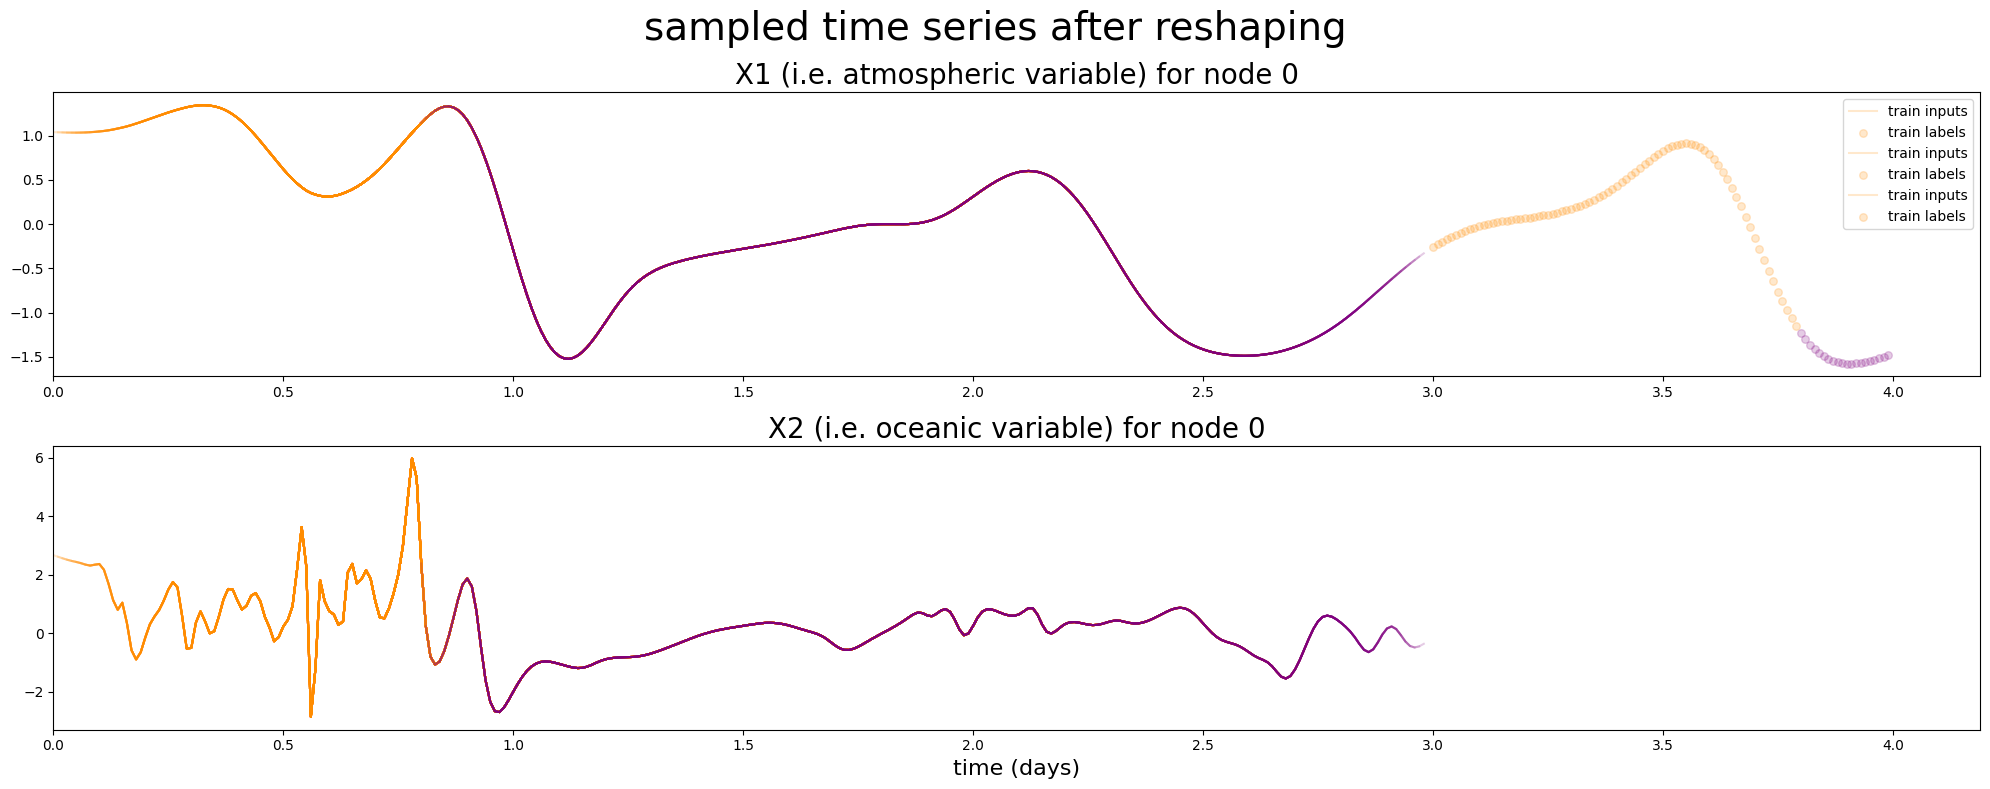

In [77]:
fig, (ax0, ax1) = plot_data(train_x1x2window, val_x1x2window, test=None, node=0)

plt.tight_layout()
plt.show()

#### predict from X2 (single value)

In [41]:
# only uncomment each line if testing a non-default parameter
dataset_x2single = lorenzDataset(
    predict_from="X2",
    n_samples=100,
    # input_steps=2 * DEFAULT_TIME_RESOLUTION,  # 2 days
    # output_delay=1 * DEFAULT_TIME_RESOLUTION,  # 1 day
    # output_steps=1,
    # min_buffer=-3 * DEFAULT_TIME_RESOLUTION,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42,
    override=True
)

generating new Lorenz data and saving to file
generating paired data
integrating for 1.0 days at 100 resolution (i.e. 100 pts)
len t vs n_steps 100 100 True
starting integration
X.shape (100, 36, 1)
Y.shape (100, 36, 1)
t.shape (100,)
reading Lorenz data from stored file


is this supposed to take this long ??

In [42]:
train_x2single = dataset_x2single[:int(0.8 * dataset_x2single.n_graphs)]
val_x2single = dataset_x2single[int(0.8 * dataset_x2single.n_graphs):]

In [43]:
# TODO: store normalized train/val/test data

# normalize data
start = datetime.now()
X1_mean, X1_std, X2_mean, X2_std = train_x2single.get_mean_std()
finish_get_means = datetime.now()
print('time to get means:', finish_get_means - start)

train_x2single.normalize(X1_mean, X1_std, X2_mean, X2_std)
val_x2single.normalize(X1_mean, X1_std, X2_mean, X2_std)
finish_normalize = datetime.now()

print('time to normalize data:', finish_normalize - finish_get_means)

time to concat: 0:00:00.001178
time to get std&mean from X1: 0:00:00.009485
time to get std&mean from X2: 0:00:00.007768
time to get means: 0:00:00.018836
time to normalize data: 0:00:00.004662


/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenz.py:346: RuntimeWarning: Mean of empty slice.
  finish_concat = datetime.now()
/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: 

In [44]:
print(type(train_x2single))
train_x2single.get_config()

<class 'lorenz.lorenzDataset'>


{'predict_from': 'X2',
 'n_samples': 100,
 'input_steps': 200,
 'output_steps': 1,
 'output_delay': 100,
 'min_buffer': 10,
 'rand_buffer': False,
 'K': 36,
 'F': 8,
 'c': 10,
 'b': 10,
 'h': 1,
 'coupled': True,
 'time_resolution': 100,
 'seed': 42}

In [59]:
print(train_x2single)
print(train_x2single[0])
print(train_x2single[0].x.shape)
print(train_x2single[0].y.shape)

lorenzDataset(n_graphs=80)
Graph(n_nodes=36, n_node_features=1, n_edge_features=None, n_labels=1)
(36, 1)
(36, 1)


inspect data
(commented out because it takes too long to plot so many data points and I'm confident I know what it looks like)

plotting train
plotting val
no training data to plot
editing legend


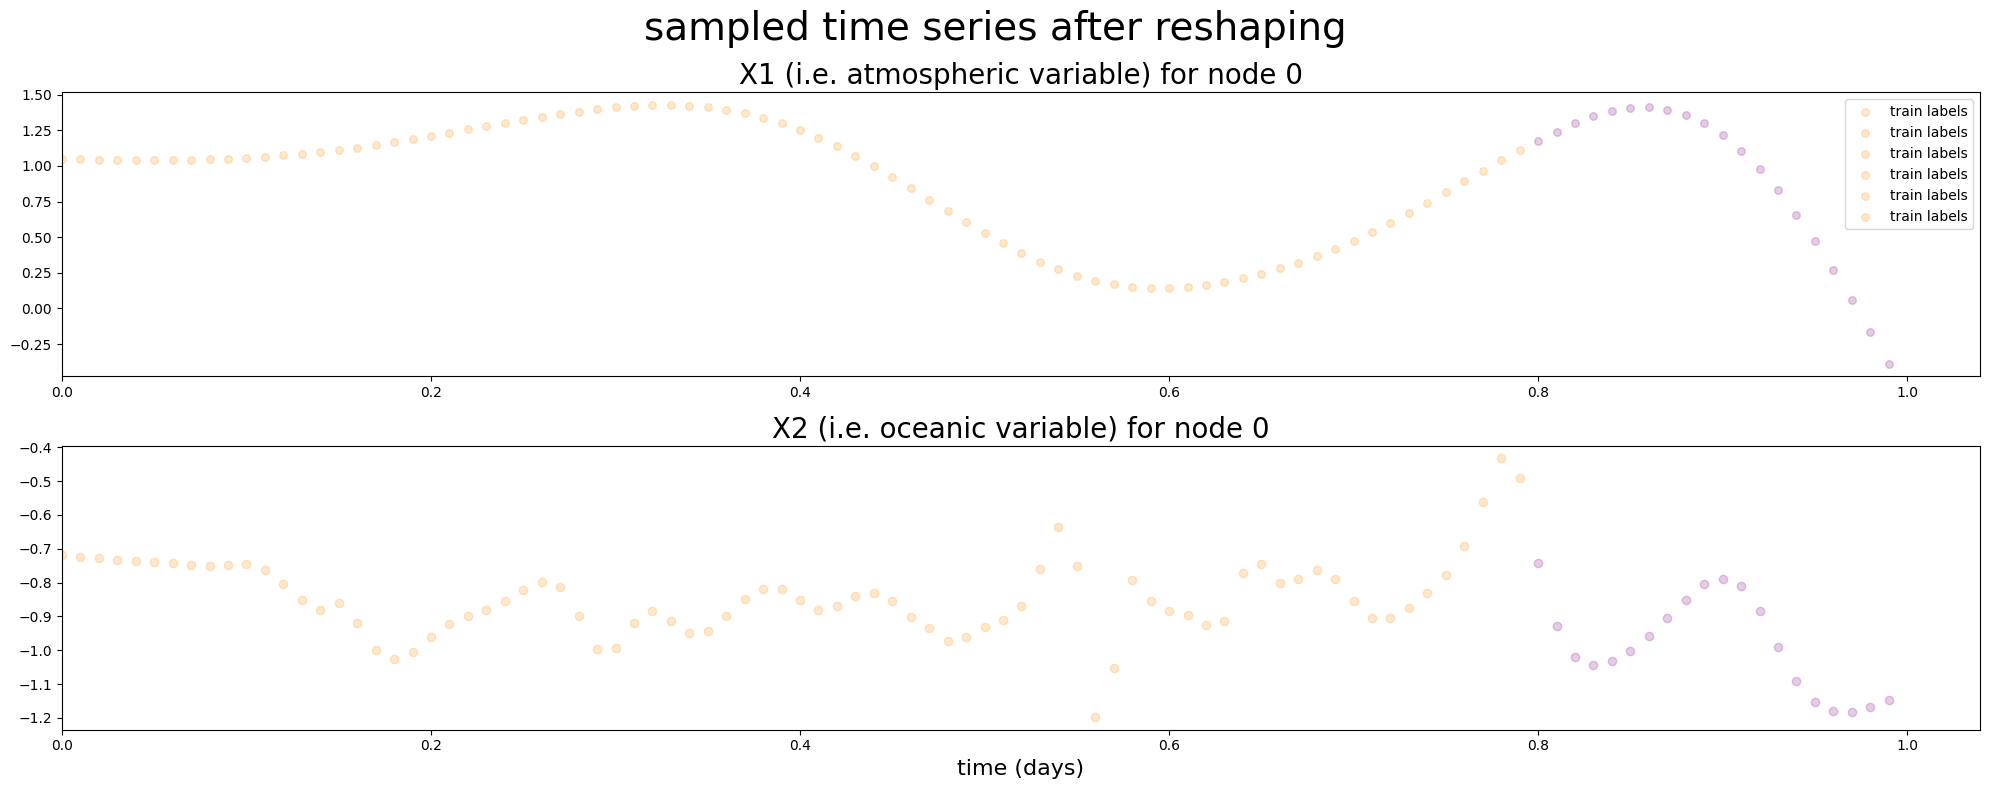

In [68]:
fig, (ax0, ax1) = plot_data(train_x2single, val_x2single, test=None, node=0)

plt.tight_layout()
plt.show()

#### predict from X2 input window

In [ ]:
# TODO: update plotting code

## run 2-layer GCN

### X1X2 window

In [81]:
model_x1x2window, history_x1x2window, fname_x1x2window = make_train_GCN(
    train_x1x2window,
    val_x1x2window,
    activation="relu",
    epochs=5,
    eval_val=True,
    tensorboard=True)


Epoch 1/5
3/3 [==============================] - 1s 144ms/step - loss: 89.1506 - val_loss: 11.5820
Epoch 2/5
3/3 [==============================] - 0s 37ms/step - loss: 72.5719 - val_loss: 5.4487
Epoch 3/5
3/3 [==============================] - 0s 35ms/step - loss: 52.0874 - val_loss: 3.4045
Epoch 4/5
3/3 [==============================] - 0s 36ms/step - loss: 47.6620 - val_loss: 3.5488
Epoch 5/5
3/3 [==============================] - 0s 37ms/step - loss: 43.5224 - val_loss: 3.7686


INFO:tensorflow:Assets written to: saved_models/gcn_3-20230221-104120/assets


INFO:tensorflow:Assets written to: saved_models/gcn_3-20230221-104120/assets


1/1 [==============================] - 0s 42ms/step


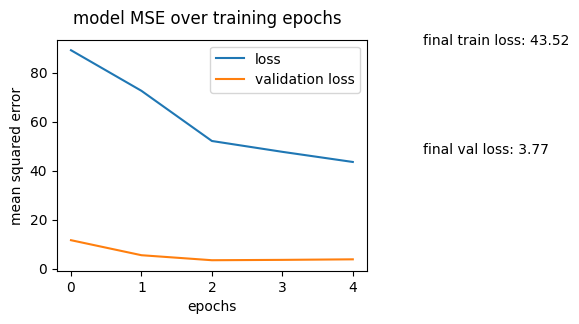

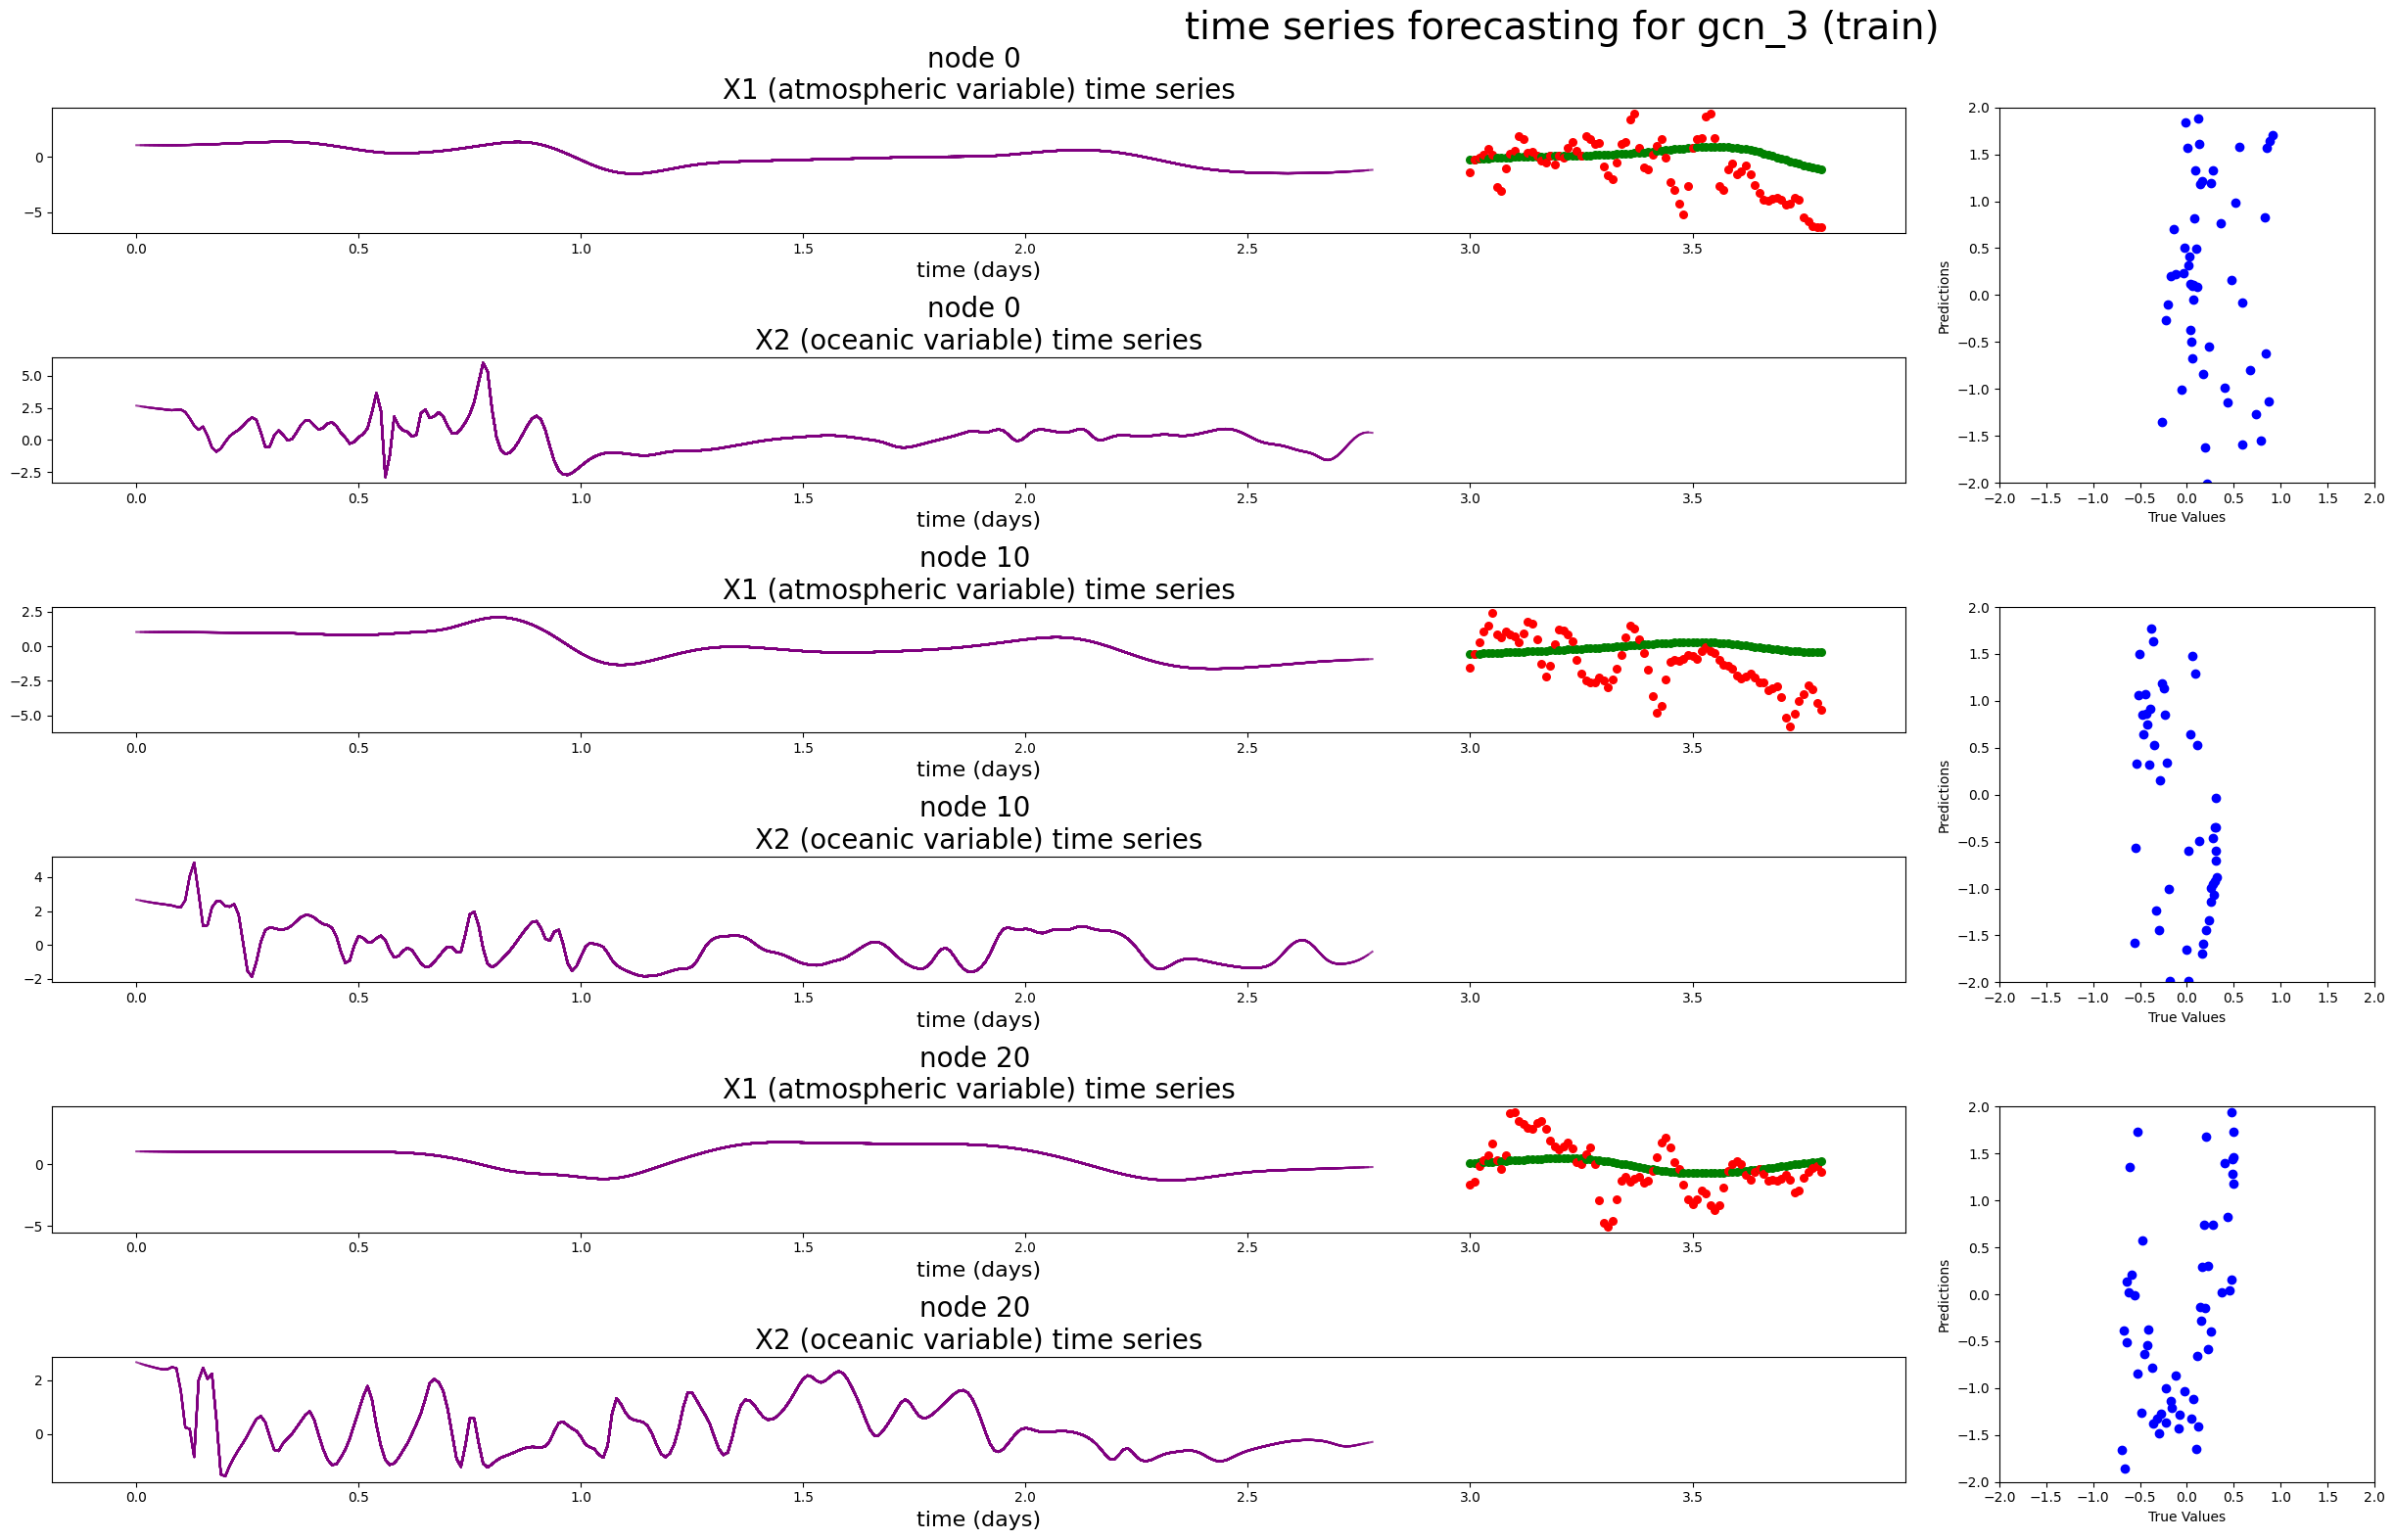

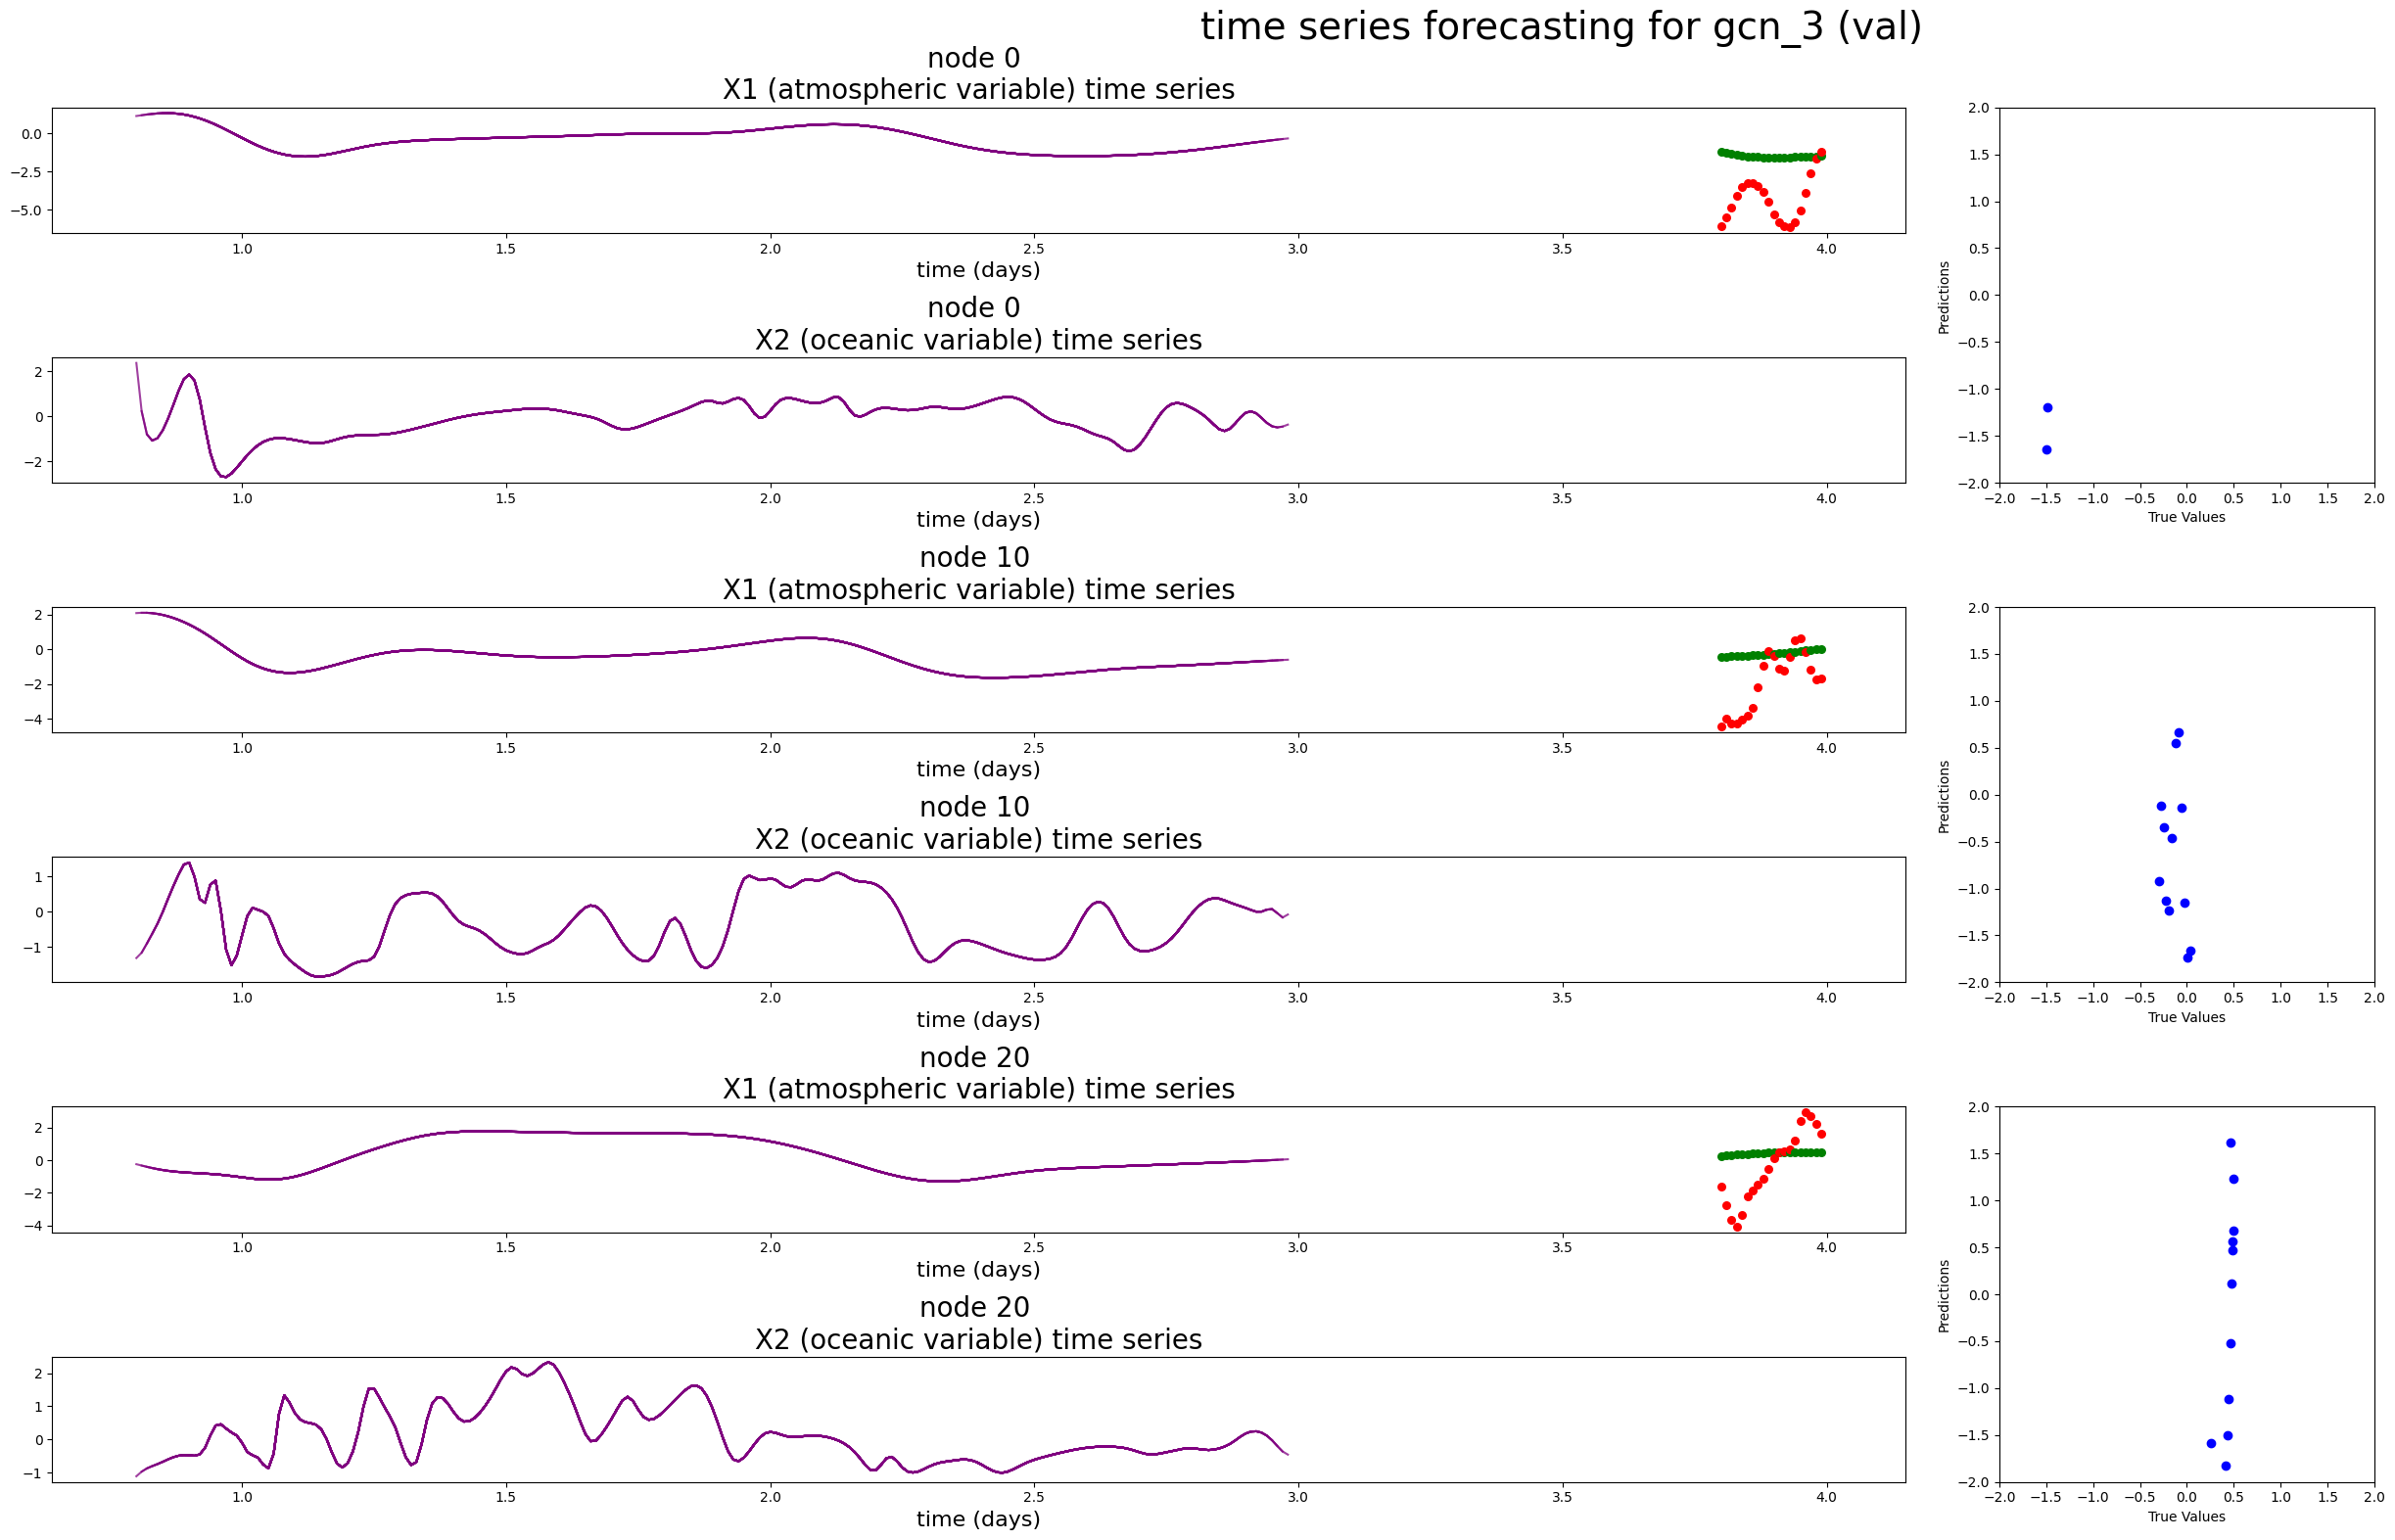

In [87]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train_x1x2window,
    val_x1x2window,
    model_x1x2window,
    history_x1x2window,
    fname=fname_x1x2window,
    epochs=5)


### predict from X2_single

In [84]:
model_x2single, history_x2single, fname_x2single = make_train_GCN(
    train_x2single,
    val_x2single,
    activation="relu",
    epochs=5,
    eval_val=True,
    tensorboard=True)


Epoch 1/5
3/3 [==============================] - 1s 135ms/step - loss: 1.6012 - val_loss: 5.3359
Epoch 2/5
3/3 [==============================] - 0s 28ms/step - loss: 1.4825 - val_loss: 4.9415
Epoch 3/5
3/3 [==============================] - 0s 27ms/step - loss: 1.3427 - val_loss: 4.5960
Epoch 4/5
3/3 [==============================] - 0s 28ms/step - loss: 1.2174 - val_loss: 4.3013
Epoch 5/5
3/3 [==============================] - 0s 29ms/step - loss: 1.2130 - val_loss: 4.0528


INFO:tensorflow:Assets written to: saved_models/gcn_4-20230221-104214/assets


INFO:tensorflow:Assets written to: saved_models/gcn_4-20230221-104214/assets


1/1 [==============================] - 0s 52ms/step


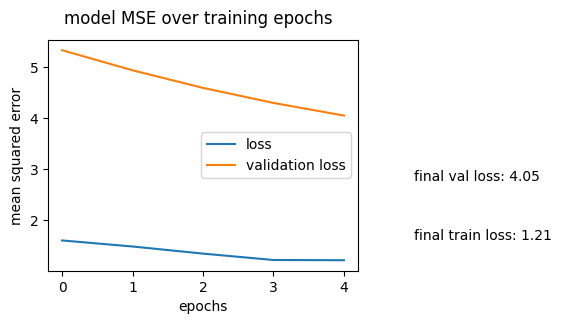

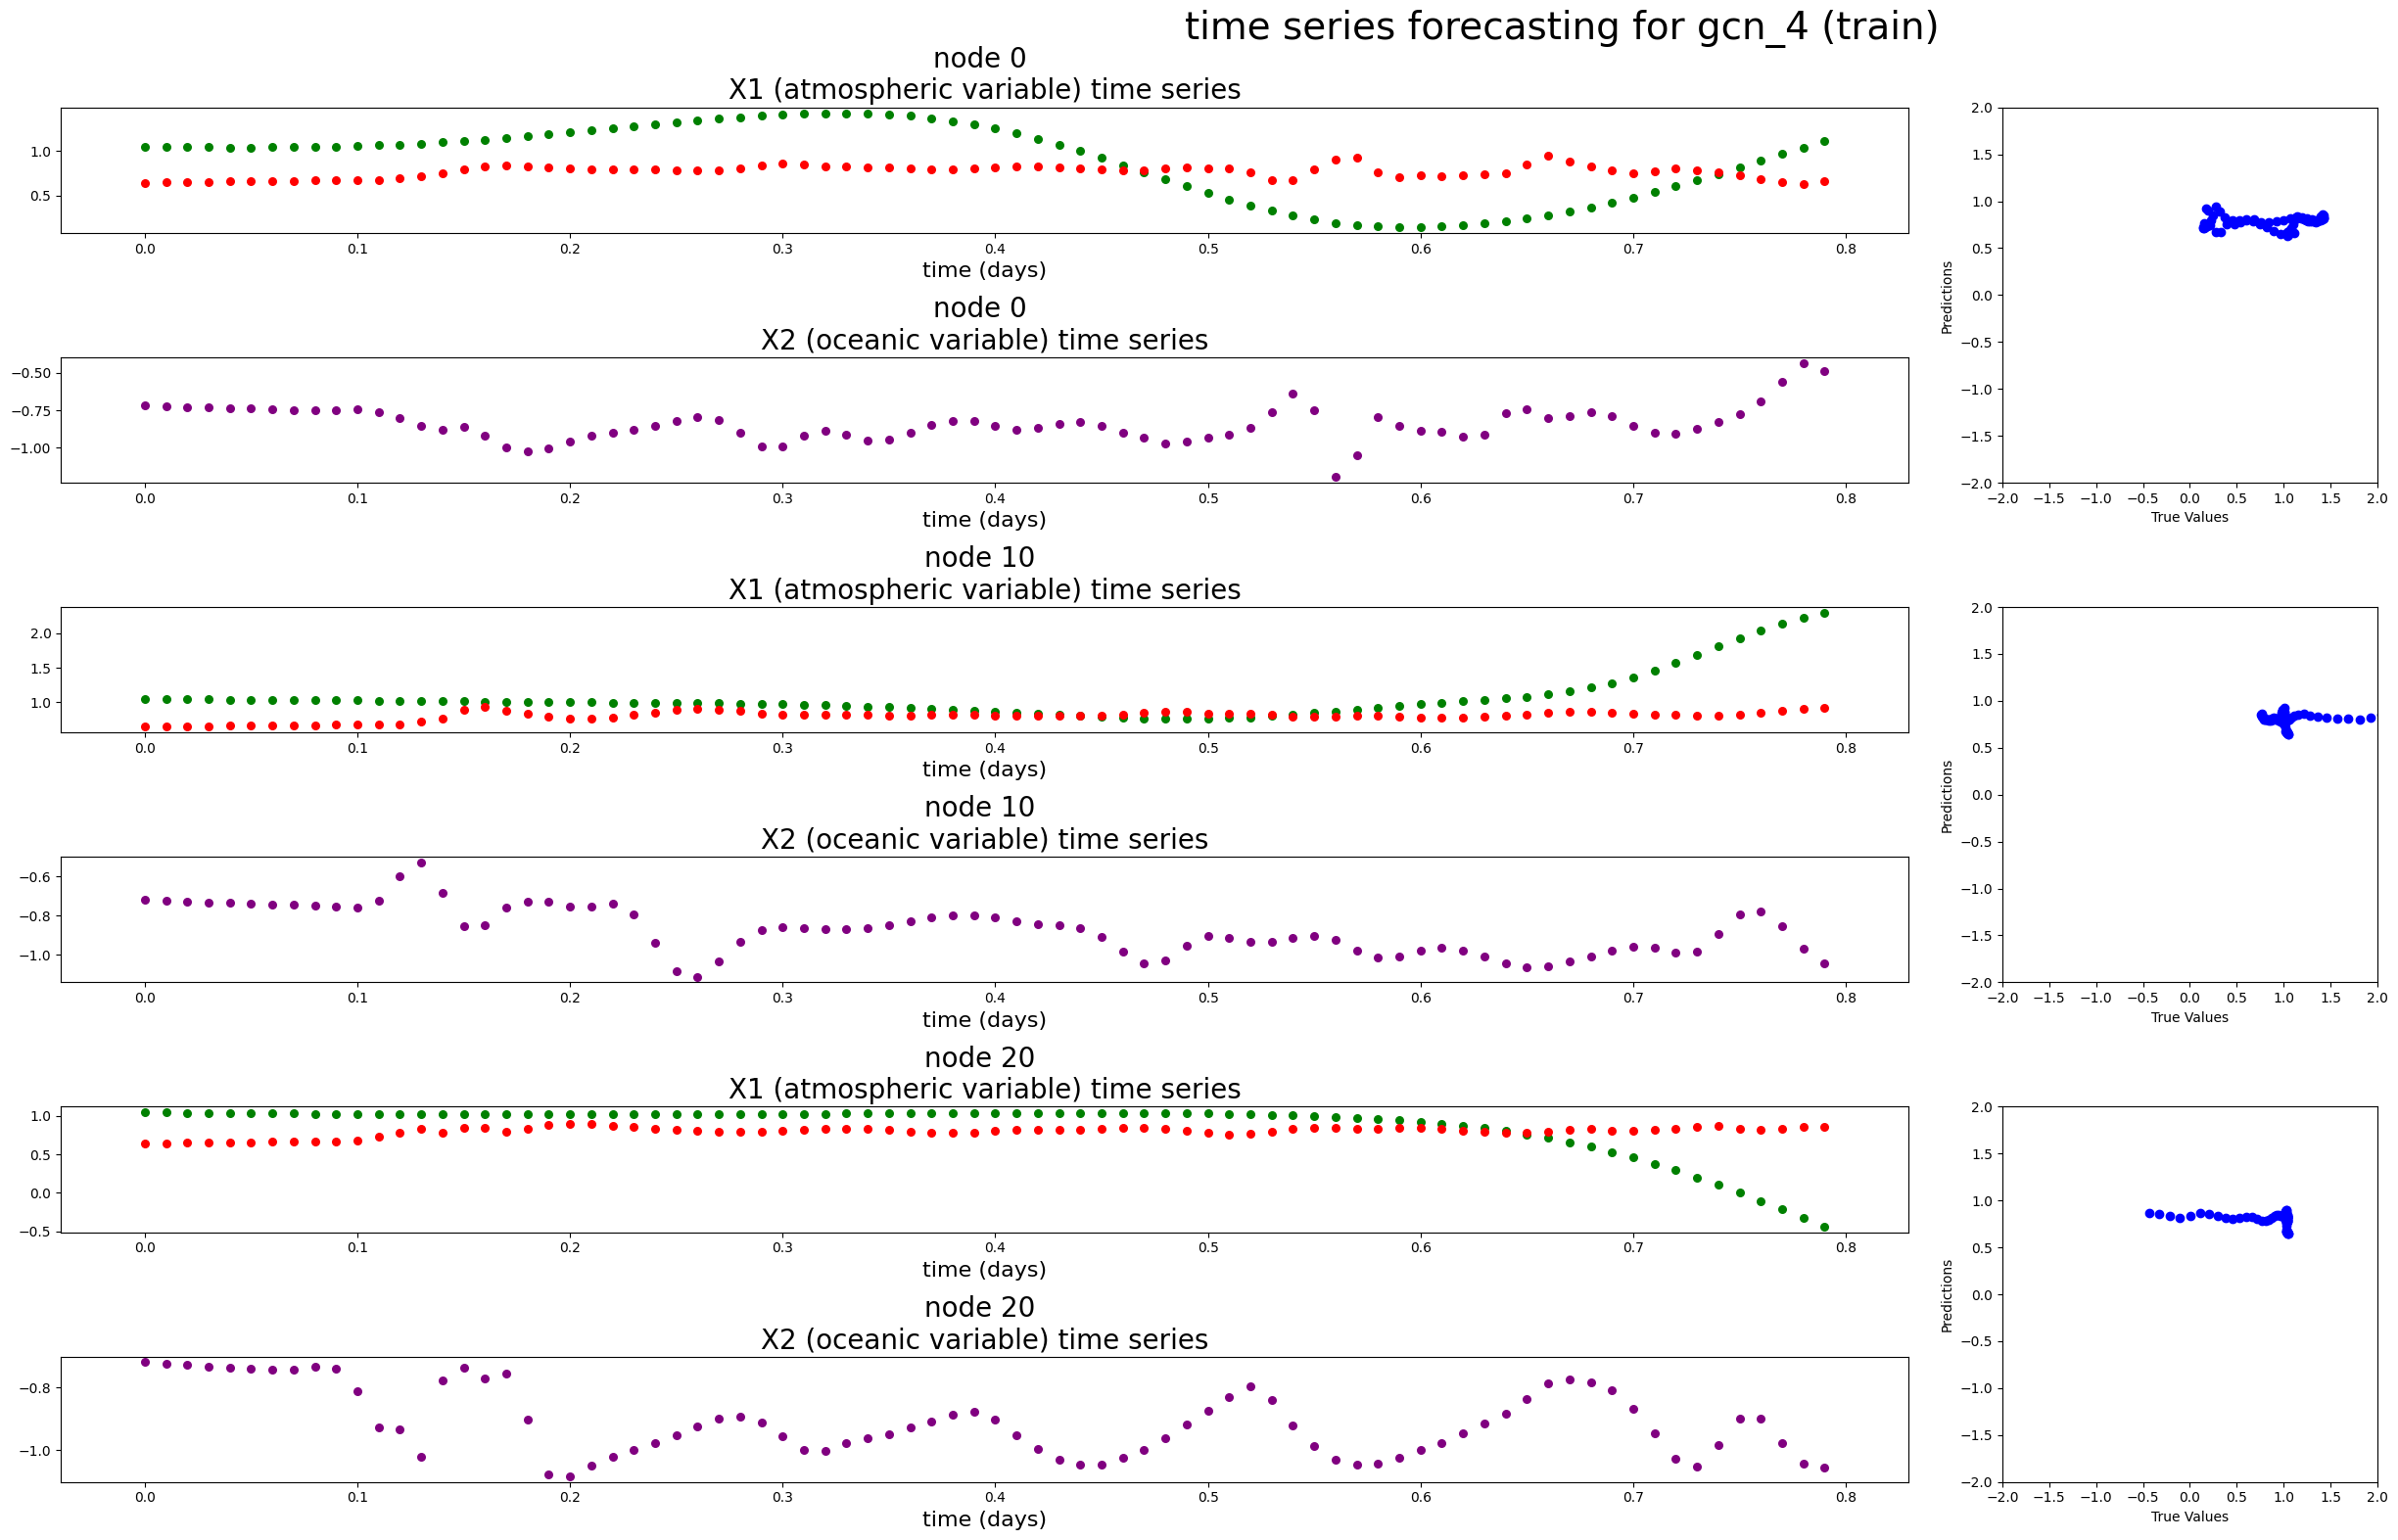

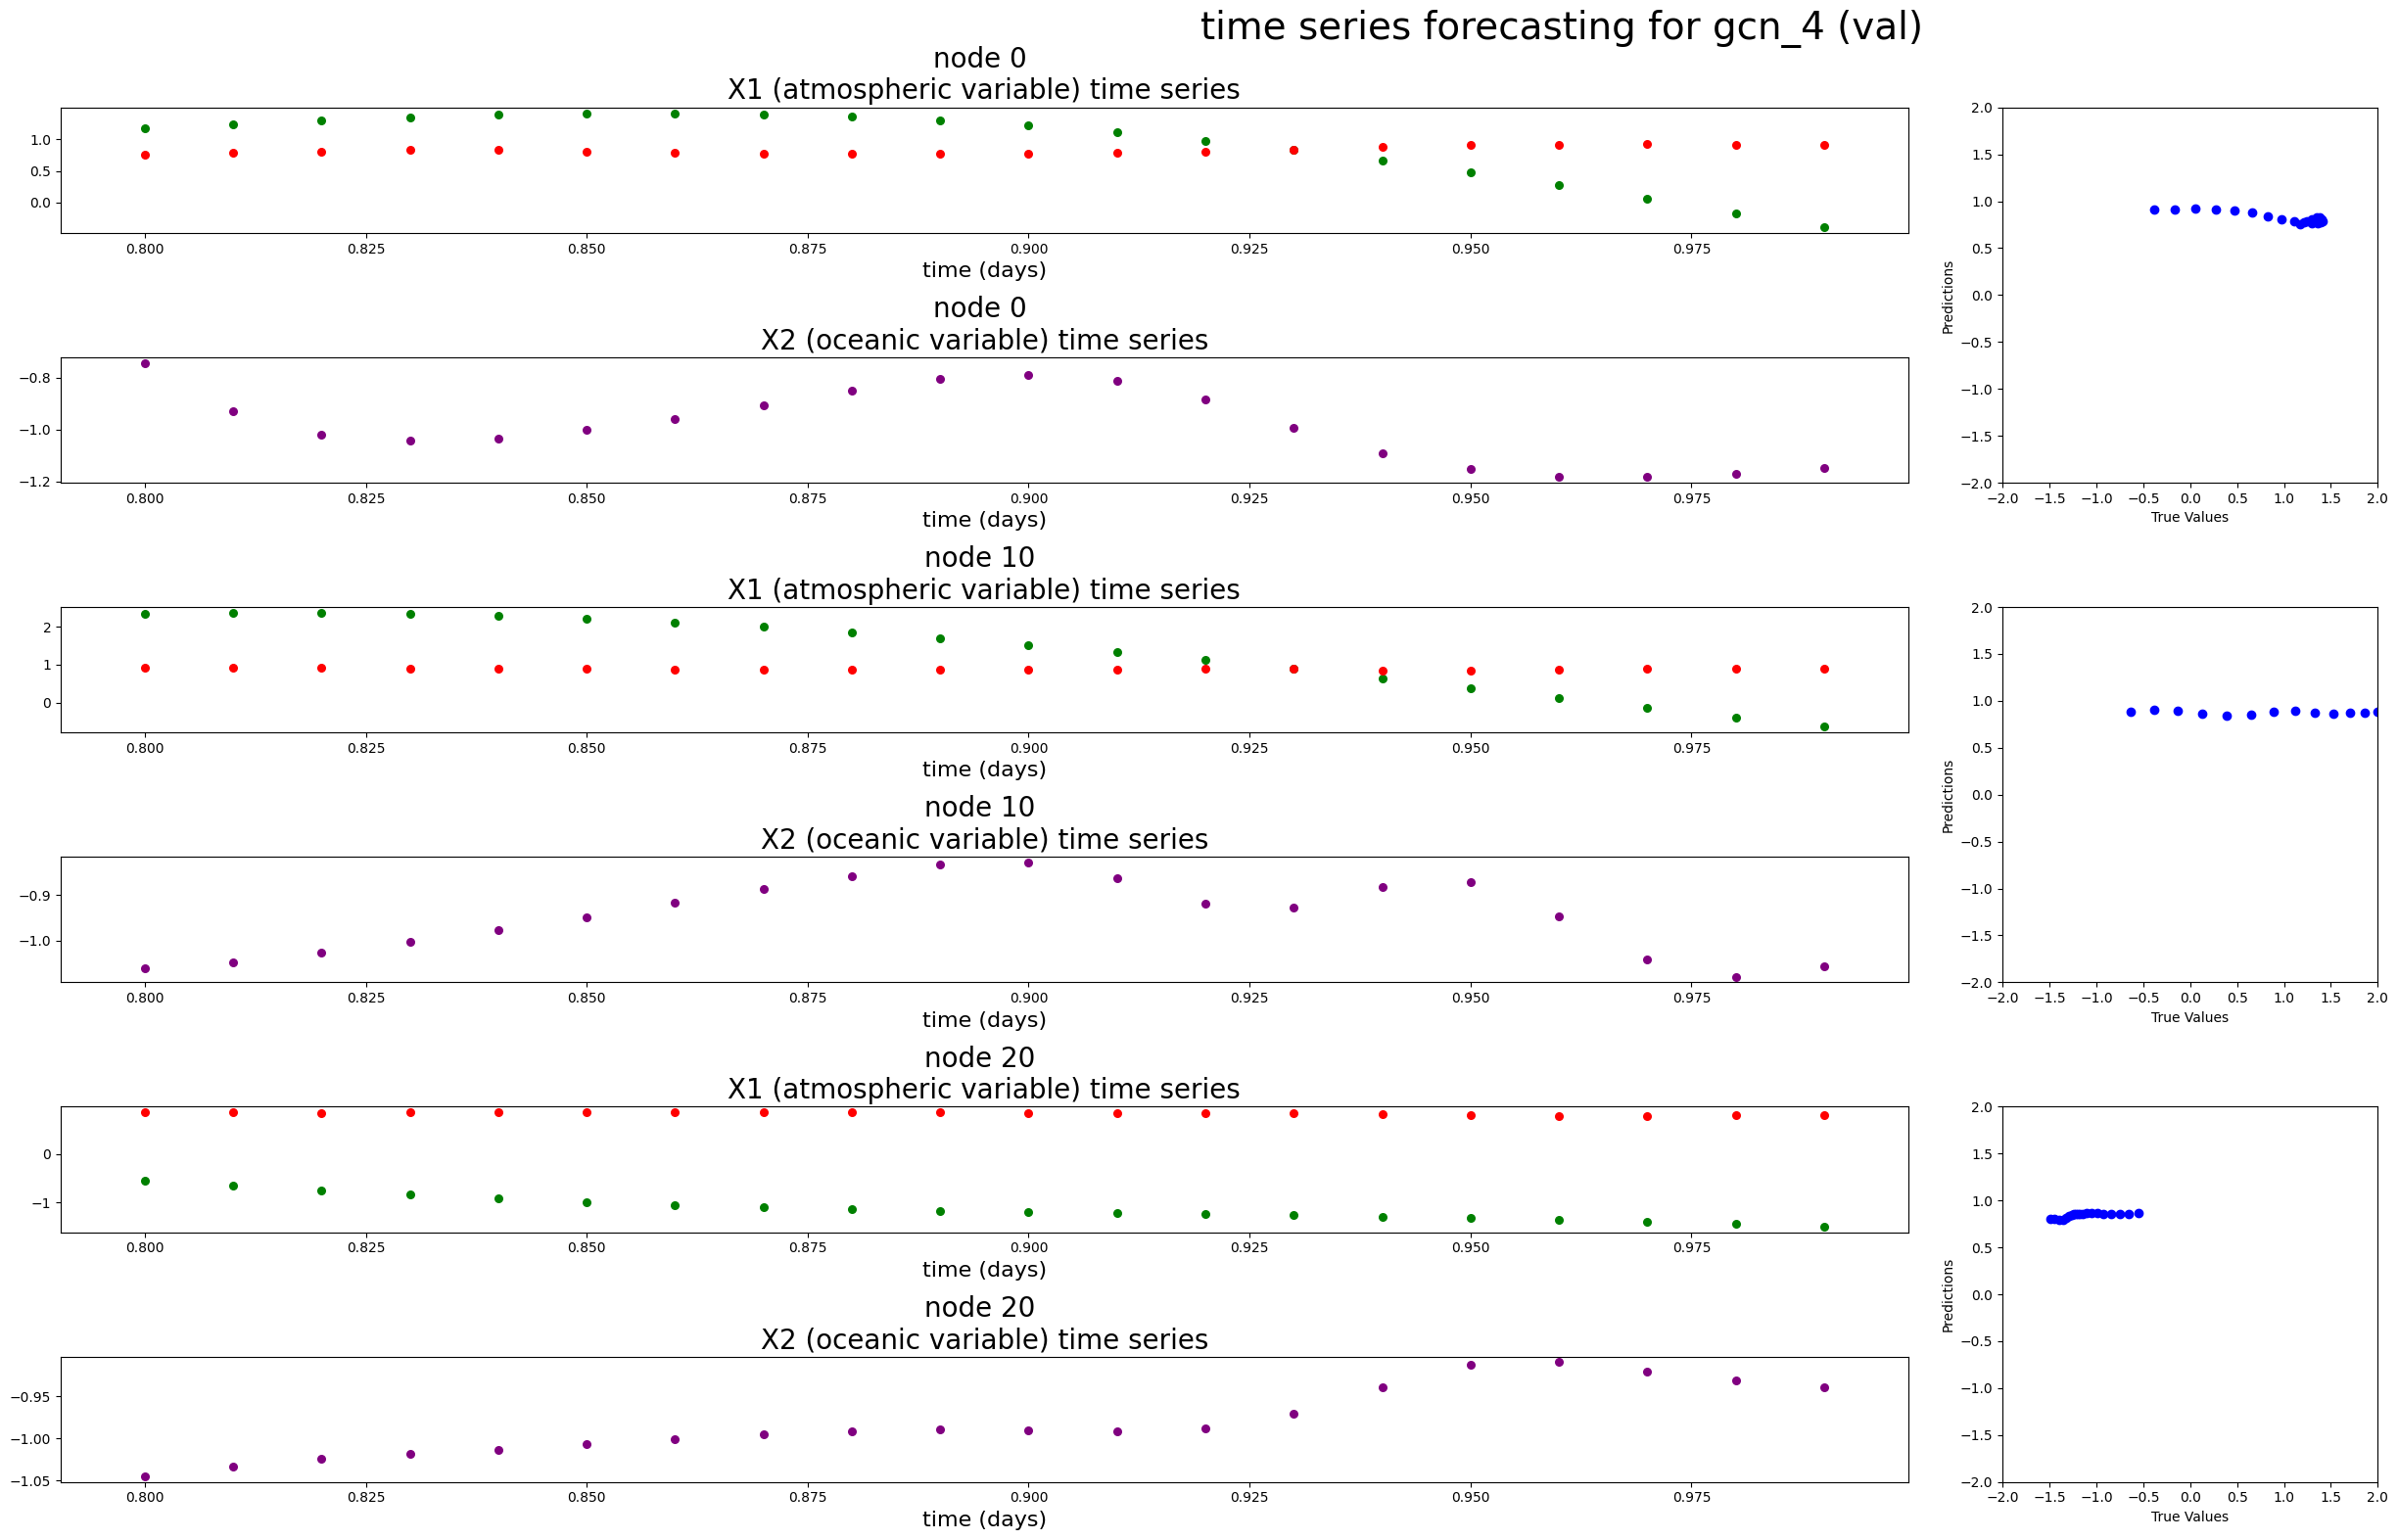

In [88]:
fig_train_loss, fig_train_pred, fig_val_pred = plot_model_results(
    train_x2single,
    val_x2single,
    model_x2single,
    history_x2single,
    fname=fname_x2single,
    epochs=5)
